In [ ]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""Data preprocessing for HCMC survey dataset"""

__author__ = "Anna Buch, Heidelberg University"
__email__ = "a.buch@stud.uni-heidelberg.de"

## Feature selection 
Enitre workflow with all models for the target variables relative content loss and business reduction (degree of loss) as well for the binary version of relative content loss (chance of loss)

Due to the samll sample size a nested CV is used to have the possibility to even get generalization error, in the inner CV the best hyperaparamters based on k-fold are selected; in the outer cv the generalization error across all tested models is evaluated. A seprate unseen validation set as done by train-test split would have an insufficent small sample size.
Nested CV is computationally intensive but with the samll sample size and a well chosen set of only most important hyperparameters this can be overcome.

- Logistic Regression (binary rcloss)
- Elastic Net
- eXtreme Gradient Boosting
- Conditional Random Forest


In [ ]:
import sys
import numpy as np
import pandas as pd

import joblib

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import make_scorer, mean_absolute_error, mean_absolute_error

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

sys.path.insert(0, "../../")
import utils.feature_selection as fs
import utils.training as t
import utils.evaluation as e
import utils.evaluation_metrics as em
import utils.figures as f
import utils.settings as s
import utils.pipelines as p
import utils.preprocessing as pp

p.main()  # create/update model settings
#s.init()
seed = s.seed

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
plt.figure(figsize=(20, 10))

import contextlib
import warnings
warnings.filterwarnings('ignore')


targets = ["Target_relative_contentloss_euro", "Target_businessreduction"]
target = targets[0]


#### Load R packages to process Conditional Random Forest in python
*Note 1: all needed R packages have to be previously loaded in R*

*Note 2: Make sure that caret package version >= 6.0-81, otherwise caret.train() throws an error*

In [ ]:
import rpy2
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr, data
import rpy2.robjects.packages as rpackages


# get basic R packages
utils = importr('utils')
base = importr('base')
dplyr = importr('dplyr')
stats_r = importr("stats")  # rename due to similar python package

# pandas.DataFrames to R dataframes 
from rpy2.robjects import pandas2ri, Formula
pandas2ri.activate()

# print r df in html
import rpy2.ipython.html
rpy2.ipython.html.init_printing()


# get libraries for CRF processing, ctree_controls etc
#partykit = importr('partykit') # for single Conditional Inference tree
party = importr('party')        # Random Forest with Conditional Inference Trees (Conditional Random Forest)
permimp = importr('permimp')  # conditional permutation feature importance
caret = importr('caret') # package version needs to be higher than  >=  6.0-90
nestedcv = importr('nestedcv')
tdr = importr("tdr")


In [ ]:
df_candidates = pd.read_excel("../../input_survey_data/input_data_contentloss_tueb.xlsx")
# df_candidates = pd.read_excel("../../input_survey_data/input_data_businessreduction_tueb.xlsx")


print(df_candidates.shape)
df_candidates.tail(2)

In [ ]:
df_candidates.describe()

In [ ]:
# df_candidates = df_candidates.drop("shp_avgmonthly_sale", axis=1)


In [ ]:

print(df_candidates.shape)
df_candidates.tail(2)


In [ ]:
## features sorted by their number of missing values
pp.percentage_of_nan(df_candidates)

df_candidates.drop("shp_avgmonthly_sale_euro", axis=1, inplace=True)


In [ ]:
## keep reislience and perception indicator
# df_candidates = df_candidates.loc[:,df_candidates.filter(regex="^(?!resilience_*)").columns]
# df_candidates = df_candidates.loc[:,df_candidates.filter(regex="^(?!perception_*)").columns]


In [ ]:
# model_name = re.findall("[a-zA-Z]+", str(pipe.steps[1][1].__class__).split(".")[-1])[0] # works only for python models  


## Fit model 

In [71]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""Featue selection with ML models for HCMC survey dataset"""

__author__ = "Anna Buch, Heidelberg University"
__email__ = "a.buch@stud.uni-heidelberg.de"

# ## Feature selection 
# Enitre workflow with all models for the target variables relative content loss and business reduction (degree of loss) as well for the binary version of relative content loss (chance of loss)
# 
# Due to the samll sample size a nested CV is used to have the possibility to even get generalization error, in the inner CV the best hyperaparamters based on k-fold are selected; in the outer cv the generalization error across all tested models is evaluated. A seprate unseen validation set as done by train-test split would have an insufficent small sample size.
# Nested CV is computationally intensive but with the samll sample size and a well chosen set of only most important hyperparameters this can be overcome.
# 
# - Logistic Regression (binary rcloss)
# - Elastic Net
# - eXtreme Gradient Boosting
# - Random Forest
# 

import sys, os
from datetime import datetime
import logging
from pathlib import Path
import joblib
import numpy as np
import pandas as pd
import re
import itertools

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import make_scorer, mean_absolute_error, mean_absolute_error

import matplotlib.pyplot as plt
import seaborn as sns

#sys.path.append(os.getcwd()+ '../../')
sys.path.insert(0, "../../")
import utils.feature_selection as fs
import utils.training as t
import utils.evaluation as e
import utils.evaluation_metrics as em
import utils.figures as f
import utils.settings as s
import utils.pipelines as p
import utils.preprocessing as pp

p.main()  # create/update model settings
#s.init()
seed = s.seed

pd.set_option('display.max_columns', None)
plt.figure(figsize=(20, 10))

import contextlib
import warnings
warnings.filterwarnings('ignore')

#### Load R packages to process Conditional Random Forest in python
# *NOTE 1: all needed R packages have to be previously loaded in R*
# *NOTE 2: Make sure that caret package version >= 6.0-81, otherwise caret.train() throws an error*
import rpy2
from rpy2.robjects import pandas2ri, Formula
from rpy2.robjects.packages import importr, data

# get basic R packages
utils = importr('utils')
base = importr('base')
dplyr = importr('dplyr')
stats_r = importr("stats")  # rename due to similar python package

# pandas.DataFrames to R dataframes 
pandas2ri.activate()

# print r df in html
import rpy2.ipython.html
rpy2.ipython.html.init_printing()

# get libraries for CRF processing, ctree_controls etc
party = importr('party')        # Random Forest with Conditional Inference Trees (Conditional Random Forest)
permimp = importr('permimp')  # conditional permutation feature importance
caret = importr('caret') # package version needs to be higher than  >=  6.0-90
nestedcv = importr('nestedcv')
tdr = importr("tdr")



targets = ["Target_relative_contentloss_euro", "Target_businessreduction"]
target = targets[0]


# Get logger  # test: init application
main_logger = f"__feature_extraction_rcloss__"
logger = s.init_logger(main_logger)

## settings for cv
kfolds_and_repeats = 3, 2 #5 # 3, 1  # <k-folds, repeats> for nested cv
cv = RepeatedKFold(n_splits=kfolds_and_repeats[0], n_repeats=kfolds_and_repeats[1], random_state=seed)

## TODO make base outdir ./model_results/degree_of_loss
##  out_dir = os.path.join(base_dir, "path")

## save models and their evaluation in following folders:
Path(f"../model_results/models_trained/degree_of_loss/nested_cv_models").mkdir(parents=True, exist_ok=True)
Path(f"../model_results/models_trained/degree_of_loss/final_models").mkdir(parents=True, exist_ok=True)
Path(f"../model_results/models_evaluation/degree_of_loss").mkdir(parents=True, exist_ok=True)
Path(f"../model_results/selected_features/degree_of_loss").mkdir(parents=True, exist_ok=True)


# df_candidates = pd.read_excel("../../input_survey_data/input_data_contentloss_tueb_cantho.xlsx")
df_candidates = pd.read_excel("../../input_survey_data/input_data_contentloss_tueb.xlsx")
# df_candidates = pd.read_excel("../../input_survey_data/input_data_businessreduction_tueb.xlsx")

# df_candidates.drop("shp_avgmonthly_sale_euro", axis=1, inplace=True)
df_candidates.drop("shp_registered_capital_euro", axis=1, inplace=True) # drop due to high collinearit with income and sale, and highest number of missing values

logger.info(df_candidates.shape)

## Fit model 
score_metrics = {
    "MAE": make_scorer(mean_absolute_error, greater_is_better=False),
    "RMSE": make_scorer(em.root_mean_squared_error, greater_is_better=False),
    "MBE": make_scorer(em.mean_bias_error, greater_is_better=False),
    "R2": "r2",
    "SMAPE": make_scorer(em.symmetric_mean_absolute_percentage_error, greater_is_better=False)
}



## empty variables to store model outputs
eval_sets = {}
models_trained = {}
final_models_trained = {}
models_coef = {}
predicted_values = {}
df_feature_importances = pd.DataFrame(index=df_candidates.drop(target, axis=1).columns.to_list())
models_scores = {}

## iterate over piplines. Each pipline contains a scaler and regressor (and optionally a bagging method) 
pipelines = ["pipe_en", "pipe_crf", "pipe_xgb"]  
# pipelines = ["pipe_crf"]  

## Load set of hyperparamters
hyperparams_set = pp.load_config("../../utils/hyperparameter_sets.json")


for pipe_name in pipelines:

    TIME0 = datetime.now()

    ## load model pipelines
    pipe = joblib.load(f'./pipelines/{pipe_name}.pkl')
 
    try:
        model_name = re.findall("[a-zA-Z]+", str(pipe.steps[1][1].__class__).split(".")[-1])[0] # get model name for python models  
    except AttributeError:
        model_name = pipe # get R model name
    
    ## load respective hyperparameter space
    pipe = joblib.load(f'./pipelines/{pipe_name}.pkl')
    param_space = hyperparams_set[f"{model_name}_hyperparameters"]

    ## if bagging fro model training is used , rename hyperparmeters
    if "bag" in pipe_name.split("_"):
        logger.info(f"Testing {model_name} with bagging")
        param_space = { k.replace('model', 'bagging__estimator') : v for (k, v) in param_space.items()}


    logger.info( f"\n############ Applying {model_name} on {target} ############\n ")

    df_Xy = df_candidates
    X_names = df_Xy.drop(target, axis=1).columns.to_list()

    ## remove zero-loss records only for combined dataset
    if target == "Target_relative_contentloss_euro":
        logger.info(f"Removing {df_Xy.loc[df_Xy[target]==0.0,:].shape[0]} zero loss records")
        df_Xy = df_Xy.loc[df_Xy[target]!=0.0,:]


    ## drop samples where target is nan
    logger.info(f"Removing {df_Xy[target].isna().sum()} records from entire dataset due that these values are nan in target variable")
    df_Xy = df_Xy[ ~df_Xy[target].isna()]

    ## Elastic Net and Random Forest: drop samples where any value is nan
    if (model_name == "ElasticNet") | (model_name == "cforest"):
        #df_Xy = df_Xy.apply(lambda x: x.fillna(x.median()), axis=0)
        df_Xy.dropna(inplace=True)
        # print("Impute records with missing values for Elastic Net or cforest",
        #        f"keeping {df_Xy.shape} damage cases for model training and evaluation")


    logger.info(
        f"Finally use {df_Xy.shape[0]} records for feature extraction, from those are {(df_Xy[target][df_Xy[target] == 0.0]).count()} cases with zero-loss or zero-reduction",
    )

    X = df_Xy[X_names]
    y = df_Xy[target]

 
    ## run sklearn model
    if model_name != "cforest":

        ## fit model for unbiased model evaluation and for final model used for Feature importance, Partial Dependence etc.
        mf = t.ModelFitting(
            model=pipe, 
            Xy=df_Xy,
            target_name=target,
            param_space=param_space,
            tuning_score=score_metrics["MAE"], # tune by getting reducing MAE
            cv=cv,
            kfolds_and_repeats=kfolds_and_repeats,
            seed=seed,
        )
        models_trained_ncv = mf.model_fit_ncv()

        # save models from nested cv and final model on entire ds
        joblib.dump(models_trained_ncv, f"../model_results/models_trained/degree_of_loss/nested_cv_models/{model_name}_{target}.joblib")
            
        ## evaluate model    
        me = e.ModelEvaluation(
            models_trained_ncv=models_trained_ncv, 
            Xy=df_Xy,
            target_name=target,
            score_metrics=score_metrics,
            cv=cv,
            kfolds=kfolds_and_repeats[0],
            seed=seed,
        )
        model_evaluation_results = me.model_evaluate_ncv()

        
        ## visual check if hyperparameter ranges are good or need to be adapted
        for i in range(len(model_evaluation_results["estimator"])):
            logger.info(f"{model_name}: ", model_evaluation_results["estimator"][i].best_params_)


        ## store models evaluation 
        models_scores[model_name] =  {
            k: model_evaluation_results[k] for k in tuple("test_" + s for s in list(score_metrics.keys()))
        } # get evaluation scores, metric names start with "test_<metricname>"
        
        ## reverse sklearn.cross_validate() outputted regression scores (e.g. MAE, RMSE, SMAPE, R2)
        models_scores[model_name] = me.negate_scores_from_sklearn_cross_valdiate(models_scores[model_name])


        ## Final model

        ## get final model based on best MAE score during outer cv
        best_idx = list(models_scores[model_name]["test_MAE"]).index(min(models_scores[model_name]["test_MAE"]))
        final_model = model_evaluation_results["estimator"][best_idx]
        logger.info(f"Params of best model: {final_model.best_params_}") 
        final_model = final_model.best_estimator_

        logger.info(f"Performance of best model:") 
        for metric in models_scores[model_name].keys():
            print(metric, models_scores[model_name][metric][best_idx])


        ## predict on entire dataset and save final model
        y_pred = final_model.predict(X) ## need to derive regression coefficients 
        final_models_trained[model_name] = final_model 
        joblib.dump(final_model, f"../model_results/models_trained/degree_of_loss/final_models/{model_name}_{target}.joblib")

        ## Feature importance of best model
        importances = me.permutation_feature_importance(final_model, repeats=5)


        ## regression coefficients for linear models from best estimator
        with contextlib.suppress(Exception):

            models_coef[model_name] = me.calc_regression_coefficients(final_model, y_pred)

            outfile = f"../model_results/models_evaluation/degree_of_loss/regression_coefficients_{model_name}_{target}.xlsx"
            models_coef[model_name].round(3).to_excel(outfile, index=True)
            logger.info(f"Regression Coefficients:\n {models_coef[model_name].sort_values('probabilities', ascending=False)} \n .. saved to {outfile}")
            
            ## check if any regression coefficient is significant 
            if np.min(models_coef[model_name]["probabilities"]) >= 0.05:
                ## non permanent decorator, extending with creation of log file for warnings
                logger = s.decorate_init_logger(s.init_logger)("__warning_coefs__") 
                logger.info("non of the regression coefficients is significant")
                logger = s.init_logger(main_logger)  # reset to previous state


    ## run R model
    else:
         ## define model settings
        mf = t.ModelFitting(
            model=pipe,  # pipe contains only name of applied R algorithm 
            Xy=df_Xy,
            target_name=target,
            param_space=param_space,
            tuning_score=score_metrics["MAE"],
            # tuning_score="neg_mean_absolute_error",
            cv=cv,
            kfolds_and_repeats=kfolds_and_repeats,
            seed=s.seed
        )
        # NOTE: normalization is not mandatory for decision-trees but might decrease processing time
        models_trained_ncv = mf.r_model_fit_ncv()  # pipe
       
        me = e.ModelEvaluation(
            models_trained_ncv=models_trained_ncv, 
            Xy=df_Xy,
            target_name=target,
            score_metrics=score_metrics,  # make optional in ModelEvlaution() class
            cv=cv,
            kfolds=kfolds_and_repeats[0],
            seed=s.seed
        )
        model_evaluation_results = me.r_model_evaluate_ncv()


        ## get std of CRF from inner folds
        ## TODO shorter name for model_evaluation_results_dict
        model_evaluation_results_dict =  {a : [] for a in ["test_MAE", "test_RMSE", "test_MBE", "test_R2", "test_SMAPE"]}
        for idx in range(1, kfolds_and_repeats[0]+1):  # number of estimators , R counts starting from 1
            df = me.r_models_cv_predictions(idx)  # get all crf estimators from outer cv
            model_evaluation_results_dict['test_MAE'].append(mean_absolute_error(df.testy, df.predy))
            model_evaluation_results_dict['test_RMSE'].append(em.root_mean_squared_error(df.testy,df.predy)) #(df.testy, df.predy)
            model_evaluation_results_dict['test_MBE'].append(em.mean_bias_error(df.testy, df.predy))
            model_evaluation_results_dict['test_R2'].append(em.r2_score(df.testy, df.predy))
            model_evaluation_results_dict['test_SMAPE'].append(em.symmetric_mean_absolute_percentage_error(df.testy, df.predy))
      
      
        ## Final CRF model
        final_model = mf.r_final_model_fit()
        best_idx = list(model_evaluation_results_dict["test_MAE"]).index(min(model_evaluation_results_dict["test_MAE"]))

        ## performance of final model 
        for metric in model_evaluation_results_dict.keys():
            logger.info(f"Performance of best model: \n{metric, model_evaluation_results_dict[metric][best_idx]}")
        
        ## Feature importance of best model
        importances = me.r_permutation_feature_importance(final_model)

        ## store model evaluation and final model
        models_scores[model_name] = model_evaluation_results_dict ## store performance scores from R estimators        
        final_models_trained[model_name] = final_model



    # ## Summarize all models and their evaluation

    ## store fitted models and their evaluation results for later 
    eval_sets[model_name] = df_Xy
    models_trained[f"{model_name}"] = models_trained_ncv
    predicted_values[model_name] = me.residuals

    ## store Feature Importances of each model
    logger.info("\nSelect features based on permutation feature importance")
    df_importance = pd.DataFrame(
        {
            f"{model_name}_importances" : importances[0],   # averaged importnace scores across repeats
            f"{model_name}_importances_std" : importances[1]
        },
        index=X_names,
    )
    df_feature_importances = df_feature_importances.merge(
        df_importance[f"{model_name}_importances"],   # only use mean FI, drop std of FI
        left_index=True, right_index=True, how="outer")
    df_feature_importances = df_feature_importances.sort_values(f"{model_name}_importances", ascending=False)  # get most important features to the top
    logger.info(f"5 most important features: {df_feature_importances.iloc[:5].index.to_list()}")


    logger.info(
    f"\nTraining and evaluation of {model_name} took {(datetime.now() - TIME0).total_seconds() / 60} minutes\n"
    )
            


## Print model evaluation based on performance on outer cross-validation 
## TODO remove overhead  -> store avergaed scores and std during loop
xgb_model_evaluation = pd.DataFrame(models_scores["XGBRegressor"]).mean(axis=0)  # get mean of outer cv metrics (negative MAE and neg RMSE, pos. R2, pos MBE, posSMAPE)
xgb_model_evaluation_std = pd.DataFrame(models_scores["XGBRegressor"]).std(axis=0)   # get respective standard deviations
crf__model_evaluation = pd.DataFrame(models_scores["cforest"]).mean(axis=0)
crf_model_evaluation_std = pd.DataFrame(models_scores["cforest"]).std(axis=0)
en_model_evaluation = pd.DataFrame(models_scores["ElasticNet"]).mean(axis=0)
en_model_evaluation_std = pd.DataFrame(models_scores["ElasticNet"]).std(axis=0)

model_evaluation = pd.concat([en_model_evaluation, en_model_evaluation_std, xgb_model_evaluation, xgb_model_evaluation_std, crf__model_evaluation, crf_model_evaluation_std], axis=1)
model_evaluation.columns = ["ElasticNet_score", "ElasticNet_score_std", "XGBRegressor_score", "XGBRegressor_score_std", "cforest_score", "cforest_score_std"]

## rename metrics
model_evaluation.index = model_evaluation.index.str.replace("test_", "")

outfile = f"../model_results/models_evaluation/degree_of_loss/performance_{target}.xlsx"
model_evaluation.round(3).to_excel(outfile, index=True)
logger.info(f"Outer evaluation scores of nested cross-validation:\n {model_evaluation.round(3)} \n.. saved to {outfile}")

## Feature Importances 

#### prepare Feature Importances 
## Have the same feature importance method across all applied ML models
## Weight Importances by model performance on outer loop (mean MAE)
## **Overall FI ranking (procedure similar to Rözer et al 2019; Brill 2022)**

## weight FI scores based on performance ; weigth importances from better performed models stronger
model_weights =  {
    "XGBRegressor_importances" : np.mean(models_scores["XGBRegressor"]["test_MAE"]),
    "ElasticNet_importances" : np.mean(models_scores["ElasticNet"]["test_MAE"]),
    "cforest_importances" : np.mean(models_scores["cforest"]["test_MAE"]),
}
df_feature_importances_w = fs.calc_weighted_sum_feature_importances(df_feature_importances, model_weights)


####  Plot Feature importances

## the best model has the highest weighted feature importance value
# df_feature_importances_w.describe()

df_feature_importances_plot = df_feature_importances_w

## drop features which dont reduce the loss
#df_feature_importances_plot = df_feature_importances_plot.loc[df_feature_importances_plot.weighted_sum_importances > 2, : ] 

f.plot_stacked_feature_importances(
    df_feature_importances_plot[["cforest_importances_weighted", "ElasticNet_importances_weighted", "XGBRegressor_importances_weighted",]],
    target_name=target,
    model_names_plot = ("Conditional Random Forest", "Elastic Net", "XGBRegressor"),
    outfile=f"../model_results/models_evaluation/degree_of_loss/feature_importances_{target}.jpg"
)


### Save final feature space 
## The final selection of features is used later for the non-parametric Bayesian Network

## drop records with missing target values
logger.info(f"Dropping {df_candidates[f'{target}'].isna().sum()} records from entire dataset due that these values are nan in target variable")
df_candidates = df_candidates[ ~df_candidates[target].isna()]
logger.info(f"Keeping {df_candidates.shape[0]} records and {df_candidates.shape[1]} features")


## sort features by their overall importance (weighted sum across across all features) 
final_feature_names = df_feature_importances_w["weighted_sum_importances"].sort_values(ascending=False).index##[:10]

## save importnat features, first column contains target variable
fs.save_selected_features(
    df_candidates, 
    pd.DataFrame(df_candidates, columns=[target]), 
    final_feature_names,
    filename=f"../selected_features/degree_of_loss/final_predictors_{target}.xlsx"
)

# ### Empirical median ~ predicted median
for k,v in predicted_values.items():
    print(f"\n{k} estimators from nested cross-validation:")
    print(em.empirical_vs_predicted(predicted_values[k]["y_true"], predicted_values[k]["y_pred"]))

## TODO impl PDP etc

logger.info("Creating boxplots for range of performane scores from outer folds of nested cross-validation")
f.boxplot_outer_scores_ncv(
    models_scores, 
    outfile=f"../model_results/models_evaluation/degree_of_loss/boxplot_scores4ncv_{target}.jpg")

11-18-2023 11:00:44 - __feature_extraction_rcloss__ - INFO - (315, 16)
11-18-2023 11:00:44 - __feature_extraction_rcloss__ - INFO - 
############ Applying cforest on Target_relative_contentloss_euro ############
 
11-18-2023 11:00:44 - __feature_extraction_rcloss__ - INFO - Removing 184 zero loss records
11-18-2023 11:00:44 - __feature_extraction_rcloss__ - INFO - Removing 0 records from entire dataset due that these values are nan in target variable
11-18-2023 11:00:44 - __feature_extraction_rcloss__ - INFO - Finally use 114 records for feature extraction, from those are 0 cases with zero-loss or zero-reduction
R[write to console]: In addition: 
R[write to console]: There were 50 or more warnings (use warnings() to see the first 50)
R[write to console]: 

R[write to console]: Fitting final model using CV on whole data

R[write to console]: Performing 3-fold outer CV, using 1 core

R[write to console]: Fitting single final model

R[write to console]: Duration: 14.53701 secs



Nested cross-validation with caret
Method:  cforest 
No filter
Outer loop:  3-fold cv
Inner loop:  3-fold repeatedcv
114 observations, 15 predictors

        mtry  n.filter
Fold 1    18        15
Fold 2    16        15
Fold 3     8        15

Final parameters:
  mtry
    16

Result:
    RMSE   Rsquared        MAE   
  0.1869     0.1159     0.1167   


11-18-2023 11:00:59 - __model_training__ - INFO - 
Summary CRF 
 $dimx
[1] 114  15

$folds
       mtry n.filter
Fold 1   18       15
Fold 2   16       15
Fold 3    8       15

$final_param
  mtry
1   16

$result
    RMSE   Rsquared        MAE   
  0.1869     0.1159     0.1167   


R[write to console]: In addition: 
R[write to console]: There were 50 or more warnings (use warnings() to see the first 50)
R[write to console]: 

R[write to console]: Fitting final model using CV on whole data

R[write to console]: Performing 3-fold outer CV, using 1 core

R[write to console]: Fitting single final model

R[write to console]: Duration: 15.49673 secs



Nested cross-validation with caret
Method:  cforest 
No filter
Outer loop:  3-fold cv
Inner loop:  3-fold repeatedcv
114 observations, 15 predictors

        mtry  n.filter
Fold 1    18        15
Fold 2    16        15
Fold 3     8        15

Final parameters:
  mtry
    16

Result:
    RMSE   Rsquared        MAE   
  0.1869     0.1159     0.1167   


11-18-2023 11:01:14 - __model_training__ - INFO - 
Summary CRF 
 $dimx
[1] 114  15

$folds
       mtry n.filter
Fold 1   18       15
Fold 2   16       15
Fold 3    8       15

$final_param
  mtry
1   16

$result
    RMSE   Rsquared        MAE   
  0.1869     0.1159     0.1167   


R[write to console]: In addition: 
R[write to console]: There were 50 or more warnings (use warnings() to see the first 50)
R[write to console]: 

11-18-2023 11:01:15 - __feature_extraction_rcloss__ - INFO - Performance of best model: 
('test_MAE', 0.1015405348297605)
11-18-2023 11:01:15 - __feature_extraction_rcloss__ - INFO - Performance of best model: 
('test_RMSE', 0.15569329795403258)
11-18-2023 11:01:15 - __feature_extraction_rcloss__ - INFO - Performance of best model: 
('test_MBE', -0.020189077169264446)
11-18-2023 11:01:15 - __feature_extraction_rcloss__ - INFO - Performance of best model: 
('test_R2', -0.05557743994775888)
11-18-2023 11:01:15 - __feature_extraction_rcloss__ - INFO - Performance of b

  |||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||| 100%


11-18-2023 11:01:18 - __feature_extraction_rcloss__ - INFO - 
Select features based on permutation feature importance
11-18-2023 11:01:18 - __feature_extraction_rcloss__ - INFO - 5 most important features: ['shp_avgmonthly_sale_euro', 'water_depth_cm', 'flowvelocity', 'emergency_measures', 'precautionary_measures_lowcost']
11-18-2023 11:01:18 - __feature_extraction_rcloss__ - INFO - 
Training and evaluation of cforest took 0.5744060833333333 minutes



KeyError: 'XGBRegressor'

<Figure size 2000x1000 with 0 Axes>

In [72]:
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
from rpy2.robjects.packages import importr

## get R packages
base = importr("base")
nestedcv = importr("nestedcv")
permimp = importr("permimp")  # conditional permutation feature importance
pdp = importr("pdp")
caret = importr('caret') # package version needs to be higher than  >=  6.0-90

# ## pandas.DataFrames to R dataframes 
# pandas2ri.activate()


Xy=df_Xy,
target_name=target,
score_metrics=score_metrics,  # make optional in ModelEvlaution() class
cv=cv,
kfolds=kfolds_and_repeats[0],

robjects.r('''
    r_get_y_pred <- function(model, verbose=FALSE) {
        model$outer_result
    }
''')
r_get_y_pred = robjects.globalenv['r_get_y_pred'] 
r_y_pred = r_get_y_pred(models_trained_ncv)
r_y_pred


R[write to console]: In addition: 
R[write to console]: There were 50 or more warnings (use warnings() to see the first 50)
R[write to console]: 



0,$preds ...
1,$preds ...
2,$preds ...


In [51]:
# import sys, os
# from datetime import datetime
# import logging
# from pathlib import Path
# import joblib
# import numpy as np
# import pandas as pd
# import re
# import itertools

# from sklearn.preprocessing import MinMaxScaler
# from sklearn.model_selection import RepeatedKFold
# from sklearn.metrics import make_scorer, mean_absolute_error, mean_absolute_error

# import matplotlib.pyplot as plt
# import seaborn as sns

# #sys.path.append(os.getcwd()+ '../../')
# sys.path.insert(0, "../../")
# import utils.feature_selection as fs
# import utils.training as t
# import utils.evaluation as e
# import utils.evaluation_metrics as em
# import utils.figures as f
# import utils.settings as s
# import utils.pipelines as p
# import utils.preprocessing as pp

# p.main()  # create/update model settings
# #s.init()
# seed = s.seed

# #df_candidates = pd.read_excel("../../input_survey_data/input_data_contentloss_tueb.xlsx")
# df_candidates = pd.read_csv("../../input_survey_data/tst_inlc_target.csv", sep=";", decimal=",")
# # df_candidates = df_candidates.iloc[:, :3]

# targets = ["Target_relative_contentloss_euro", "Target_businessreduction"]
# target = targets[0]


# # Get logger  # test: init application
# main_logger = f"__feature_extraction_rcloss__"
# logger = s.init_logger(main_logger)

# ## settings for cv
# kfolds_and_repeats = 3, 2 #5 # 3, 1  # <k-folds, repeats> for nested cv
# cv = RepeatedKFold(n_splits=kfolds_and_repeats[0], n_repeats=kfolds_and_repeats[1], random_state=seed)


# import rpy2.robjects as robjects
# from rpy2.robjects import pandas2ri
# from rpy2.robjects.packages import importr

# caretStack = importr("caretStack")
# caret = importr("caret")
# party = importr("party")

# df_candidates =  df_candidates.dropna()
# df_candidates = df_candidates.loc[df_candidates[target]!=0.0,:]
# print(df_candidates.shape, target)


# from sklearn.preprocessing import MinMaxScaler
# df_candidates = df_candidates.reset_index(drop=True)
# df_candidates_X = pd.DataFrame(MinMaxScaler().fit_transform(df_candidates.drop(target, axis=1)), columns=df_candidates.drop(target, axis=1).columns)
# pd.concat([df_candidates_X, df_candidates[target]], axis=1)
# df_Xy = pd.concat([df_candidates_X, df_candidates[target]], axis=1)           
# print(df_candidates_X.shape, target)
# print(df_candidates[target].shape, target)
# print(df_Xy.shape, target)

# df_Xy[target] = df_Xy[target].astype("float64")


# ## caretStack_rNCV has no interface for python such as caret package
# robjects.r('''
#       caretStack_rNCV <- function(df_Xy, target, verbose=FALSE) {
            
#            df_Xy$Target_relative_contentloss_euro <-  as.numeric(as.character(df_Xy$Target_relative_contentloss_euro))

#             caretStack::predict_two(
#                   df_Xy,
#                   "Target_relative_contentloss_euro",
#                   targetType = "numerical",
#                   predictor_var_file_list="../../input_survey_data/tst.csv",
#                   outDir = "",
#                   rdata_prefix="",
#                   rNCVdir = "rNCV",
#                   nFolds.outer = 5,
#                   nRep = 5,
#                   methods ="cforest",
#                   metric = "RMSE",
#                   ncore = 1,
#                   cmp.grp = NA,
#                   ctrl.reg = caret::trainControl(
#                         method = "repeatedcv", 
#                         number = 10,  
#                         repeats = 5,  
#                         savePredictions ="final",
#                         search="random"
#                   )
#             )
#       }
# ''')
# caretStack_rNCV = robjects.globalenv['caretStack_rNCV'] 

# models_trained_ncv = caretStack_rNCV(
#       df_Xy, #[["Target_relative_contentloss_euro","inundation_duration_h", "water_depth_cm"]],
#       "Target_relative_contentloss_euro"
# )
# models_trained_ncv


In [10]:
#     #     rNCV(
#     #         data=df_Xy,
#     #         resp.var=target,
#     #         nRep=5, 
#     #         nFolds.outer=10,
#     #         methods="cforest",
#     #         metric="RMSE",
#     #         preProcess="range",
#     #         dir.path=".",
#     #         file.root="test_r_rNC_",
#     #         tuneLength=3,
#     #         save.PredVal=TRUE,
#     #         trControl=caret::trainControl(
#     #               method = "repeatedcv", 
#     #               number = 10,  
#     #               repeats = 5,  
#     #               savePredictions ="final",
#     #               search="random"
#     #         )
#     #   )     
# df_candidates = pd.read_csv("../../input_survey_data/tst_inlc_target.csv", sep=";", decimal=",")
# df_candidates = df_candidates.iloc[:, :3]
# df_candidates#.info()
df_Xy

,inundation_duration_h,water_depth_cm,Target_relative_contentloss_euro
0,0.019183,0.121622,0.009208
1,0.002502,0.006757,0.008059
2,0.000000,0.054054,0.003997
3,0.010842,0.324324,0.007994
4,0.010842,0.128378,0.399989
...,...,...,...
122,0.004170,0.391892,0.845666
123,0.004170,0.189189,0.040569
124,0.004170,0.189189,0.026734
125,0.005838,0.391892,0.155515


In [46]:


# def r_models_cv_predictions(models_trained_ncv, idx=0):
#     """
#     Get y_pred and y_true for a certain model during CV in R
#     model : fitted R model from nestedcv.train()
#     idx (int): index position of trained model from inner cv
#     return: pandas Dataframe with y_pred and y_test values 
#     """
#     robjects.r('''
#         r_models_cv_predictions <- function(m, idx, verbose=FALSE) {
#             m$outer_result[[idx]]$preds
#         }
#     ''') 
#     r_model_prediction = robjects.globalenv['r_models_cv_predictions']

#     return fs.r_dataframe_to_pandas(r_model_prediction(models_trained_ncv, idx))

# t = r_models_cv_predictions(models_trained_ncv, 4)
# t

In [45]:
# nestedcv = importr("nestedcv")
# print(kfolds_and_repeats)

# models_trained_ncv = nestedcv.nestcv_train(
#     y= df_Xy["Target_relative_contentloss_euro"],
#     x=df_Xy.drop("Target_relative_contentloss_euro", axis=1),
#     method="cforest",  
#     outer_method="cv",
#     outer_train_predict=True, # save predictions on outer folds
#     n_outer_folds=kfolds_and_repeats[0],
#     n_inner_folds=kfolds_and_repeats[0],
#     finalCV=False,  # False= return average of the best hyperparameters from outer CV folds for continuous/ ordinal hyperparamet
#     # NOTE if finalCV=True # model is fitted again on entire dataset which is biased due that samples were already seen during model tuning
#     # We want the final model as the model which performed best during outer cv
#     # tuneGrid=self.r_tunegrid(
#     #     self.param_space["mtry"][0], 
#     #     self.param_space["mtry"][1], 
#     #     self.param_space["mtry"][2]
#     # ), 
#     metric='MAE',
#     controls = party.cforest_unbiased( ntree = 300),
#     trControl = caret.trainControl(
#         method = "repeatedcv", 
#         number = kfolds_and_repeats[0],  
#         repeats = kfolds_and_repeats[1],  
#         savePredictions ="all",  # "final"= save predictions for the optimal tunning params
#         search="random"
#     ))

R[write to console]: Fitting final model using CV on whole data

R[write to console]: Performing 3-fold outer CV, using 1 core



(3, 2)


R[write to console]: Error: Stopping

R[write to console]: In addition: 
R[write to console]: Warning messages:

R[write to console]: 1: model fit failed for Fold1.Rep1: mtry=2 Error in (function (formula, data = list(), subset = NULL, weights = NULL,  : 
  unused argument (repeats = 2)
 

R[write to console]: 2: model fit failed for Fold2.Rep1: mtry=2 Error in (function (formula, data = list(), subset = NULL, weights = NULL,  : 
  unused argument (repeats = 2)
 

R[write to console]: 3: model fit failed for Fold3.Rep1: mtry=2 Error in (function (formula, data = list(), subset = NULL, weights = NULL,  : 
  unused argument (repeats = 2)
 

R[write to console]: 4: model fit failed for Fold1.Rep2: mtry=2 Error in (function (formula, data = list(), subset = NULL, weights = NULL,  : 
  unused argument (repeats = 2)
 

R[write to console]: 5: model fit failed for Fold2.Rep2: mtry=2 Error in (function (formula, data = list(), subset = NULL, weights = NULL,  : 
  unused argument (repeats = 2)


RRuntimeError: Error: Stopping


In [86]:
# r_y_pred[0][0]
# fs.r_dataframe_to_pandas(r_y_pred[0][1])

(3, 2)

In [ ]:
# df_y_pred = pd.DataFrame()
# for i in range(k_folds):
#     df_y_pred = pd.concat(
#         [df_y_pred, fs.r_dataframe_to_pandas(r_y_pred[i][0])], # r_y_pred[i][0] == y_pred of one outer fold
#         axis=0)
# df_y_pred.reset_index(drop=True)

# y_true = np.array(df_y_pred["testy"])
# y_pred = np.array(df_y_pred["predy"])

# # get generalization performance on outer folds of nested cv, 
# # y_pred are the predictions from the outer cv
# model_performance_ncv = {          ## TODO scores slightly differ from the average number of performance scores for each estimator
#     "test_MAE" : mean_absolute_error(y_true, y_pred),   # TODO get metrics names fro self.score_metrics
#     "test_RMSE" : em.root_mean_squared_error(y_true, y_pred),
#     "test_MBE" : em.mean_bias_error(y_true, y_pred),
#     # "test_R2": r2_score(y_true, self.y_pred),
#     "test_SMAPE" : em.symmetric_mean_absolute_percentage_error(y_true, y_pred),
# }
# model_performance_ncv



In [57]:
models_scores["cforest"]
len(models_scores["cforest"]["test_MAE"])


{'test_MAE': [0.1015405348297605, 0.11272859034386716, 0.1363152269736161],
 'test_RMSE': [0.15569329795403258, 0.16936562103716563, 0.22904458789351048],
 'test_MBE': [-0.020189077169264446,
  -0.020602951551626066,
  0.04283447128024753],
 'test_R2': [-0.05557743994775888, 0.11674697716881222, 0.14562430421637185],
 'test_SMAPE': [101.02277813410683, 95.70020903600955, 104.4153499406422]}

In [58]:
# ## Final CRF model
# # final_model = mf.r_final_model_fit()
# logger.info(f"Performance of best model:") 
# for metric in ["test_MAE", "test_RMSE", "test_MBE", "test_R2", "test_SMAPE"]:
#     print(metric, models_scores["cforest"][metric][best_idx])

len(models_scores["cforest"][metric])

3

In [35]:
# models_trained_ncv

R[write to console]: Fitting final model using CV on whole data

R[write to console]: Performing 10-fold outer CV, using 1 core

Exception ignored from cffi callback <function _callback at 0x000001FDB672F550>:
Traceback (most recent call last):
  File "c:\Anaconda\envs\py396_c3\lib\site-packages\rpy2\rinterface_lib\callbacks.py", line 329, in _callback
    try:
KeyboardInterrupt: 
R[write to console]: Fitting single final model

R[write to console]: Duration: 8.997016 mins



0,call,$call (fu...
1,output,...
2,outer_result,[[1]] [[1...
3,outer_method,['cv']
4,outer_folds,$Fold01 ...
5,dimx,[1] 114 15
6,xsub,...
7,y,[0.009207...
...,...,...
14,finalTune,mtry 1 10
15,summary,[0.183056...


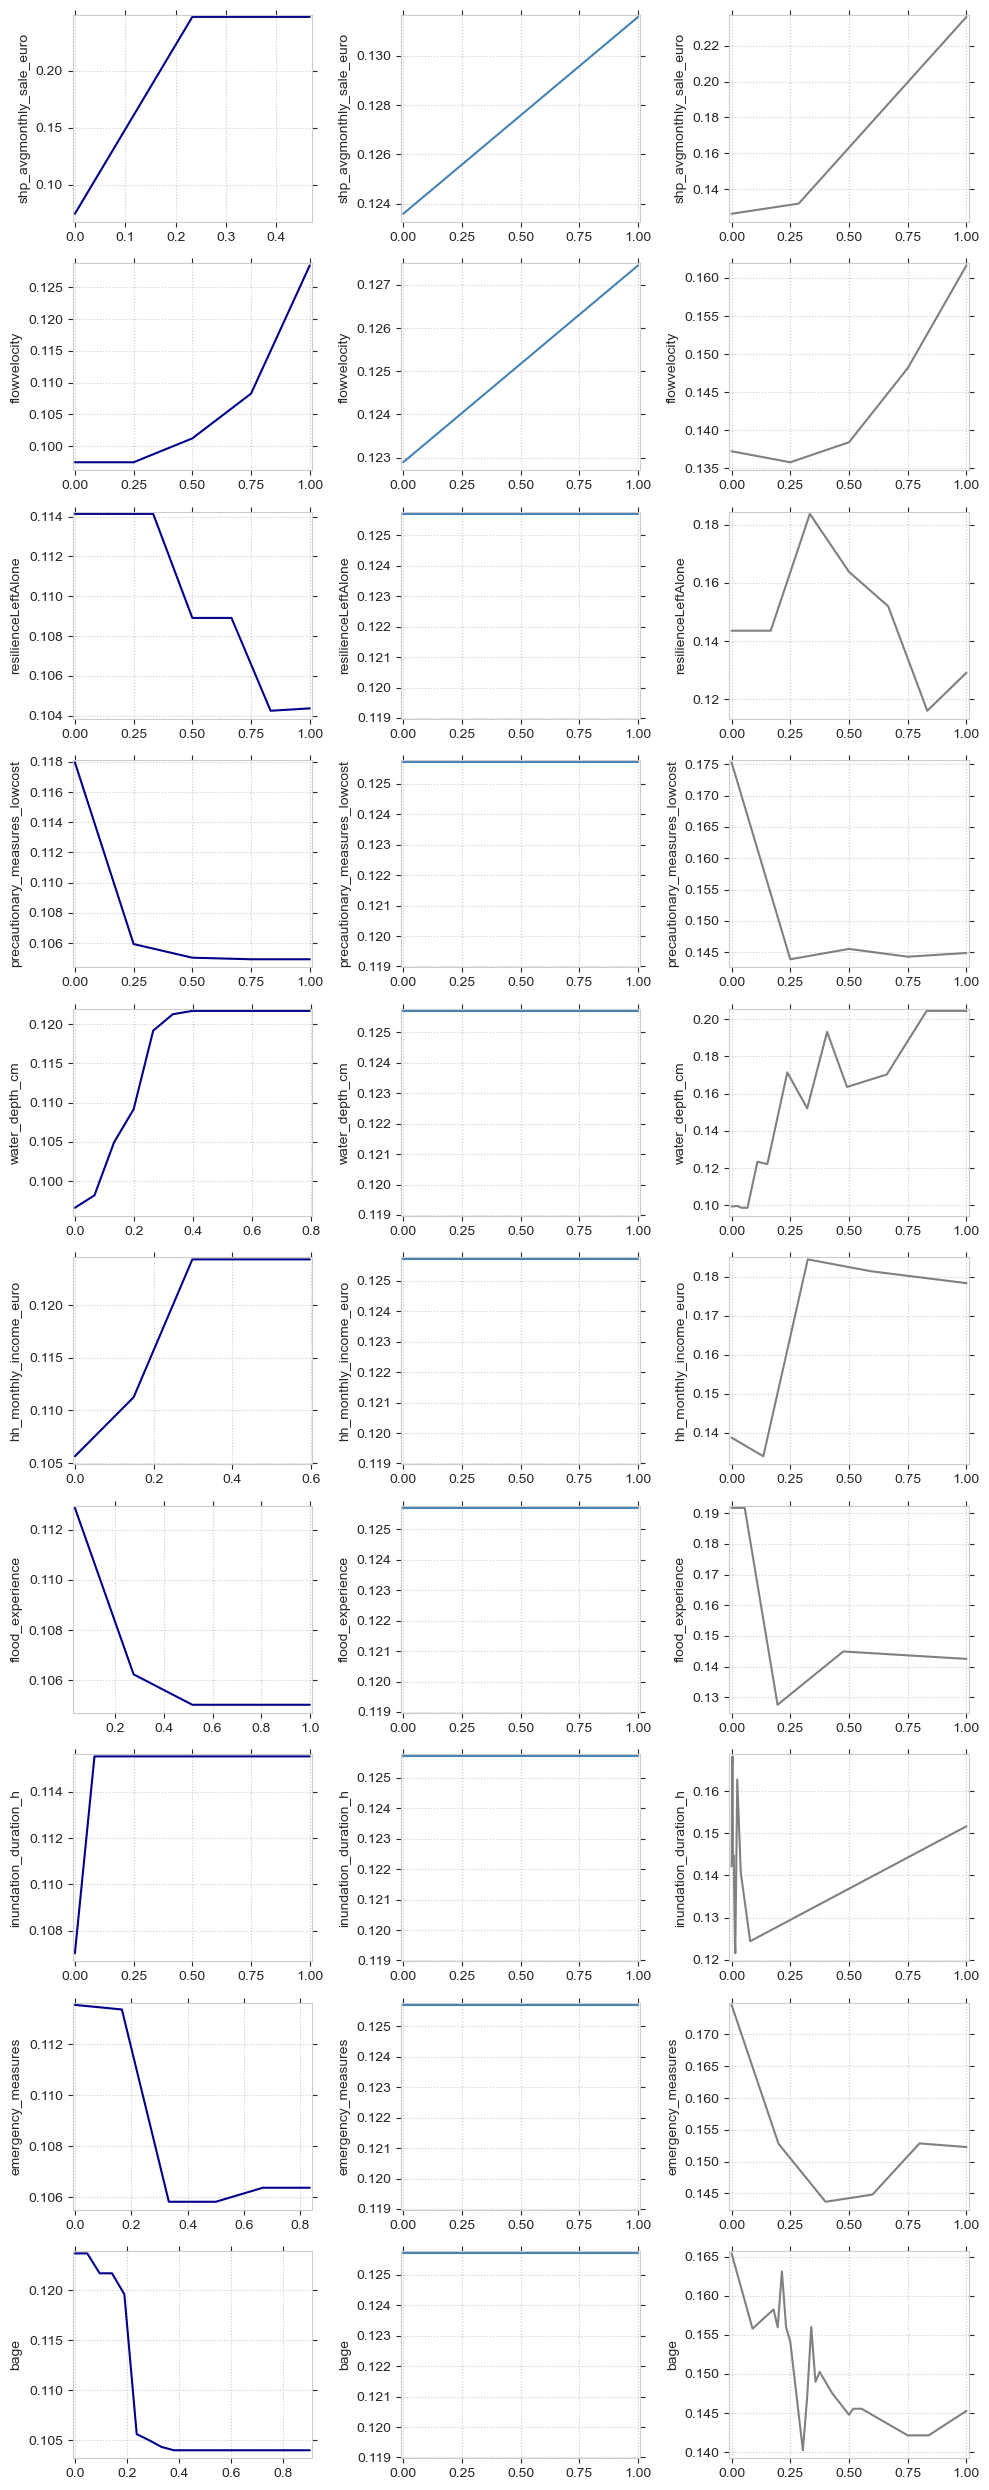

In [34]:
### Partial dependence
## PDP shows the marginal effect that one or two features have on the predicted outcome.

## store partial dependences for each model
pdp_features = {a : {} for a in ["ElasticNet", "XGBRegressor", "cforest"]}

for model_name in ["cforest", "ElasticNet", "XGBRegressor"]:

    Xy_pdp = eval_sets[model_name].dropna() #  solve bug on sklearn.partial_dependece() which can not deal with NAN values
    X_pdp, y_pdp = Xy_pdp[Xy_pdp.columns.drop(target)], Xy_pdp[target]
    X_pdp = pd.DataFrame(
        MinMaxScaler().fit_transform(X_pdp), # for same scaled pd plots across models
        columns=X.columns
        )
    Xy_pdp = pd.concat([y_pdp, X_pdp], axis=1)

    for predictor_name in X.columns.to_list(): 
        features_info =  {
            #"percentiles" : (0.05, .95) # causes NAN for some variables for XGB if (0, 1)
            "model" : final_models_trained[model_name], 
            "Xy" : Xy_pdp, 
            "y_name" : target, 
            "feature_name" : predictor_name, 
            "scale"  : True
        }  
        # get Partial dependences for sklearn models      
        if model_name != "cforest": 
            partial_dep = me.get_partial_dependence(**features_info)
        # get Partial dependences for R models      
        else:  
            #  change function only temporary to process R model instead of sklearn models
            partial_dep = me.decorator_func(**features_info) (me.get_partial_dependence)()  

        pdp_features[model_name][predictor_name] = partial_dep


## Plot PDP

most_important_features = df_feature_importances_plot.sort_values("weighted_sum_importances", ascending=False).index

categorical = [] # ["flowvelocity", "further_variables .."]
ncols = 3
nrows = len(most_important_features[:10])
idx = 0

plt.figure(figsize=(10,25))
# plt.suptitle(f"Partial Dependences for {target}", fontsize=18, y=0.95)


## create PDP for all three models
for feature in most_important_features[:10]:
    for model_name, color, idx_col in zip(["cforest", "ElasticNet", "XGBRegressor"], ["darkblue", "steelblue","grey"], [0, 1, 2]):
        
        # idx position of subplot
        ax = plt.subplot(nrows, ncols, idx + 1 + idx_col)
        feature_info = {"color" : color, "ax" : ax} 

        # plot
        df_pd_feature = pdp_features[model_name][feature]  
        p = f.plot_partial_dependence(
            df_pd_feature, 
            feature_name=feature, 
            partial_dependence_name="yhat", 
            categorical=[],
            outfile=f"../model_results/models_evaluation/degree_of_loss/pdp_{target}.jpg",
            **feature_info
            )
        p
                # sns.rugplot(df_pd_feature, x=df_pd_feature[feature_name], 
                #     y=df_pd_feature[partial_dependence_name], 
                #     height=-.02)
        

    idx = idx + 3



In [ ]:
# ### Empirical median ~ predicted median
# Compare median and mean of predicted  vs observed target values
for k,v in predicted_values.items():
    print(f"\n{k}")
    print(em.empirical_vs_predicted(predicted_values[k]["y_true"], predicted_values[k]["y_pred"]))


# ### Plot prediction error 
f.plot_residuals(
    residuals=predicted_values, 
    model_names_abbreviation=["cforest", "ElasticNet", "XGBRegressor"],  
    model_names_plot=["Conditional Random Forest", "Elastic Net", "XGBoost"],
    outfile=f"../model_results/models_evaluation/degree_of_loss/residuals_{target}.jpg"
)


print(f"Finished processing for target {target}")  # TODO add time measure at least for nested cv



<!-- Outer evaluation scores:
        ElasticNet_score  ElasticNet_score_std  XGBRegressor_score   
MAE               0.132                 0.004               0.112  \
RMSE              0.197                 0.031               0.178   
MBE              -0.000                 0.028               0.012   
R2               -0.007                 0.012               0.092   
SMAPE          -113.807                 9.608             -98.403   

       XGBRegressor_score_std  cforest_score  cforest_score_std  
MAE                     0.006          0.117              0.014  
RMSE                    0.021          0.181              0.027  
MBE                     0.029         -0.006              0.015  
R2                      0.132          0.161              0.015  
SMAPE                   8.596        101.061              5.033    -->

In [ ]:
## visual check if hyperparameter ranges are good or need to be adapted
for i in range(len(model_evaluation_results["estimator"])):
    print(f"{model_name}: ", model_evaluation_results["estimator"][i].best_params_)

# ## closs

# ## Bred
# # {'model__seed': 42, 'model__n_estimators': 400, 'model__max_depth': 7, 'model__booster': 'gblinear'}
# # {'model__tol': 0.5, 'model__selection': 'random', 'model__random_state': 42, 'model__max_iter': 4, 'model__l1_ratio': 0.0, 'model__alpha': 1}


## Evaluation
Evaluate models based on performance on outer cross-validation 

In [ ]:
## get std of CRF from inner folds
l = []
for idx in range(1,10):  # number of estimators in outer folds
    
    df = me.r_models_cv_predictions(models_trained["cforest"], idx)

    mae = mean_absolute_error(df.testy, df.predy)
    rmse =  np.sqrt( np.mean((df.testy - df.predy)**2) ) #(df.testy, df.predy)
    mbe = e.mean_bias_error(df.testy, df.predy)
    r2 = mean_absolute_error(df.testy, df.predy)
    smape = e.symmetric_mean_absolute_percentage_error(df.testy, df.predy)
    l.append([mae, rmse, mbe, r2, smape ])


In [ ]:
print("CRF: mean of evaluation scores and their standard deviation across tested models in inner cv:",
        f"\nmae_mean, mae_std: {np.mean([score[0] for score in l]), np.std([score[0] for score in l]) } ",
        f"\nrmse_mean, rmse_std: {np.mean([score[1] for score in l]), np.std([score[1] for score in l]) } ",
        f"\nmbe_mean, mbe_std: {np.mean([score[2] for score in l]), np.std([score[2] for score in l]) } ",
        f"\nr2_mean, r2_std: {np.mean([score[3] for score in l]), np.std([score[3] for score in l]) } ",
        f"\nsmape_mean, smape_std: {np.mean([score[4] for score in l]), np.std([score[4] for score in l]) } ",
)

print("\nElastic Net: mean of evaluation scores and their standard deviation across tested models in inner cv:",
    pd.concat([
            pd.DataFrame(models_scores["ElasticNet"]).drop("estimator",axis=1).mean(axis=0),
            pd.Series(pd.DataFrame(models_scores["ElasticNet"]).drop("estimator",axis=1).std(axis=0))
        ], axis=1
    )
      )

print("\nXGB: mean of evaluation scores and their standard deviation across tested models in inner cv:",
    pd.concat([
            pd.DataFrame(models_scores["XGBRegressor"]).drop("estimator",axis=1).mean(axis=0),
            pd.Series(pd.DataFrame(models_scores["XGBRegressor"]).drop("estimator",axis=1).std(axis=0))
        ], axis=1
    )
    )

# EN
# test_neg_MAE    -0.062560  0.019390
# test_neg_RMSE   -0.113259  0.069073
# test_MBE        -0.000050  0.032531
# test_R2         -0.432757  1.121662
# test_SMAPE    -127.259363  9.495025

# XGB: mean of evaluation scores and their standard deviation across tested models in inner cv:                         0          1
# fit_time        21.798437   0.712181
# score_time       0.012409   0.002156
# test_neg_MAE    -0.067284   0.018891
# test_neg_RMSE   -0.142585   0.061684


## best model for BRed : XGB test_MAE    -16.769906    2.025747  (no subsampling of feautres)
## best model for BRed : XGB test_MAE    -16.007160    1.684777  (with subsampling of feautres) 


In [ ]:
xgb_model_evaluation = pd.DataFrame(models_scores["XGBRegressor"]).drop("estimator",axis=1).mean(axis=0)  # get mean of outer cv metrics (negative MAE and neg RMSE, pos. R2, pos MBE, posSMAPE)
#crf_model_evaluation = pd.DataFrame(models_scores["cforest"]).mean(axis=0)
en_model_evaluation = pd.DataFrame(models_scores["ElasticNet"]).drop("estimator",axis=1).mean(axis=0)

# Applying xgb on Target_relative_contentloss_euro:
# outer CV: MAE: -0.095 (0.032)


## TODO add/derive MBE, MAPE of CRF
crf_model_evaluation = pd.DataFrame({
    "cforest": [None, 
            None,
            round(np.mean([score[0] for score in l]), 3), # MAE
            round(np.mean([score[1] for score in l]), 3),  # RMSE
            round(np.mean([score[2] for score in l]), 3), # MBE 
            round(np.mean([score[3] for score in l]), 3),  # R2
            round(np.mean([score[4] for score in l]), 3), # SMAPE 
            ]

    }, index=xgb_model_evaluation.index
)

model_evaluation = pd.concat([en_model_evaluation, xgb_model_evaluation, crf_model_evaluation], axis=1)
model_evaluation.columns = ["ElasticNet", "XGBRegressor", "cforest"]
model_evaluation.index = model_evaluation.index.str.replace("neg_", "")
model_evaluation.loc["test_MAE"] = model_evaluation.loc["test_MAE"].abs()
model_evaluation.loc["test_RMSE"] = model_evaluation.loc["test_RMSE"].abs()


model_evaluation.round(3)

### Coefficients of Elastic Net

EN: The coefficients of elastic net regression represent the linear relationship between the features and the target variable, adjusted by the regularization terms. The larger the absolute value of a coefficient, the stronger the effect of the corresponding feature on the target variable. The sign of a coefficient indicates the direction of the effect. 

**Note: The regularization reduces the influence of correlated variables on the model because the weight is shared between the two predictive variables, so neither alone would have strong weights.**

[https://scikit-learn.org/stable/auto_examples/inspection/plot_linear_model_coefficient_interpretation.html#checking-the-variability-of-the-coefficients]


sklearn:
odds_ratio = exp(coef)
where exp is the exponential function and coef is the coefficient for the input variable. The odds_ratio represents the change in the odds of the output variable for a one-unit increase in the input variable. A value greater than 1 indicates that the odds of the output variable increase with an increase in the input variable

In [ ]:
#.reset_index(drop=True).set_index(list(X.columns).insert(0, "intercept"))

models_coef#["en_selfbuilt"].sort_values("Probabilities")


#### Coefficient variability

High variabaility indicates possible strong collinearity with other features

Coefficient of ML models are generally unable to infer causal effects.
It might be tempting to look at the coefficient of education on wage from our last model (or any model for that matter) and conclude that it captures the true effect of a change in the standardized education variable on wages.
Unfortunately there are likely **unobserved confounding variables** that either inflate or deflate that coefficient. A confounding variable is a variable that causes both EDUCATION and WAGE.

In [ ]:
cv_en_model = models_scores["ElasticNet"] ## get scores of each feature in each fold (outer folds * inner folds)
len(cv_en_model["estimator"])

In [ ]:
cv_en_model = models_scores["ElasticNet"] ## get scores of each feature in each fold (outer folds * inner folds)
len(cv_en_model["estimator"])
coefs = pd.DataFrame(
    # [est[-1].best_estimator_.named_steps['model'].coef_ for est in cv_en_model["estimator"]]
    [est.best_estimator_.named_steps['model'].coef_ for est in cv_en_model["estimator"]], columns=X.columns
)


In [ ]:
#coefs.mean(axis=0)

In [ ]:
plt.figure(figsize=(9, 7))
sns.stripplot(data=coefs, orient="h", palette="dark:k", alpha=0.5)
sns.boxplot(data=coefs, orient="h", color="steelblue", saturation=0.7, whis=100)
plt.axvline(x=0, color=".5")
plt.title("Coefficient variability of Elastic Enet")
plt.subplots_adjust(left=0.3)



--> coefficients of flowvelocity and purchase pumping equipment varying a lot depneding of the fold
--> registered capital, average monthly sale, monthly income coefficients are varying a lot depending of the fold.

**The regularization reduces the influence of correlated variables on the model because the weight is shared between the two predictive variables, so neither alone would have strong weights.**

### Feature Importances 


#### prepare Feature Importances 
Have the same feature importance method across all applied ML models
Weight Importances by model performance on outer loop (mean MAE)

In [ ]:
s = df_feature_importances

In [ ]:
## Overall FI ranking (procedure similar to Rözer et al 2019; Brill 2022)

## scale importance scores to  same units (non important feautres were removed before)
df_feature_importances = pd.DataFrame(
    MinMaxScaler(feature_range=(0,10)).fit_transform(df_feature_importances), 
    index=df_feature_importances.index,
    columns=df_feature_importances.columns
)
print(df_feature_importances.head(2))


In [ ]:
## weight FI scores based on performance 
## weigth importances from better performed models more

crf_scores = models_scores[f"cforest"] ["MAE"] # outer MAE of CRF

for m in ["XGBRegressor", "ElasticNet"]: 
    df_feature_importances[f"{m}_importances_weighted"] =  df_feature_importances[f"{m}_importances"] / np.abs(models_scores[m]["test_MAE"].mean())
df_feature_importances["cforest_importances_weighted"]  = df_feature_importances["cforest_importances"] / crf_scores    # weigth better models more

df_feature_importances.head(2)


In [ ]:
## overall FI scores
df_feature_importances["mean_all_importances_weighted"] = df_feature_importances[["XGBRegressor_importances_weighted","ElasticNet_importances_weighted", "cforest_importances_weighted"]].mean(axis=1)
## drop feautres which are unimportant
df_feature_importances = df_feature_importances.loc[df_feature_importances["mean_all_importances_weighted"] > 0.000000, : ]
print(
    "10 most important features across all models (weighted on mean MAE scores):\n" ,
    #df_feature_importances.overall_importances.sort_values(ascending=False).head()
)
df_feature_importances.sort_values("mean_all_importances_weighted", ascending=False)[:10]#.describe()


In [ ]:
## save to disk
df_feature_importances.to_excel(
    f"../../input_survey_data/selected_predictors/feature_importances_allmodels_{target.split('_')[1]}.xlsx", 
    index=False
)


####  Plot Feature importances

In [ ]:
## the best model has the highest weighted feature importance value
# df_feature_importances.describe()

In [ ]:
#df_feature_importances = df_feature_importances_logreg
df_feature_importances["sum_all_importances_weighted"] = df_feature_importances.fillna(0)["XGBRegressor_importances_weighted"] + df_feature_importances.fillna(0)["ElasticNet_importances_weighted"] + df_feature_importances.fillna(0)["cforest_importances_weighted"]
df_feature_importances = df_feature_importances.sort_values("sum_all_importances_weighted", ascending=True)
df_feature_importances.head(5)

In [ ]:
df_feature_importances

In [ ]:
### drop features which dont reduce the loss
df_feature_importances_plot = df_feature_importances#.loc[df_feature_importances.sum_all_importances_weighted > 0.01, : ] 
#df_feature_importances_plot = df_feature_importances.loc[df_feature_importances.sum_all_importances_weighted > 2, : ] 
#df_feature_importances_plot = df_feature_importances.sort_values("mean_all_importances_weighted", ascending=True)

plt.figure(figsize=(30, 22))
#df_feature_importances.plot.barh(
df_feature_importances_plot[["cforest_importances_weighted", "ElasticNet_importances_weighted", "XGBRegressor_importances_weighted",]].plot.barh(
    stacked=True, 
    #color="darkblue",
    color={"cforest_importances_weighted":"darkblue", "ElasticNet_importances_weighted":"steelblue", "XGBRegressor_importances_weighted":"grey"},
    width=0.5,
    # #errorbar="sd",
    # errorbar=("pi", 50), 
    # capsize=.1, errcolor=".5",
    # linewidth=3,
    )
plt.xlabel("Importance")
plt.ylabel("")
plt.title(f"Feature Importances for {target.replace('_',' ')}")


top_bar = mpatches.Patch(color="darkblue", label="Conditional Random Forest")
middle_bar = mpatches.Patch(color="steelblue", label="Elastic Net")
bottom_bar = mpatches.Patch(color="grey", label="XGBoost")
plt.tick_params(axis='x', which='major', labelsize=12)
plt.tick_params(axis='y', which='major', labelsize=12)
plt.legend(handles=[top_bar, middle_bar, bottom_bar], loc="lower right")
#plt.tight_layout()
#plt.grid(None)

plt.show()

#sns.despine(left=True, bottom=True)
## save importance scores and figure
#filepath = f'./model_results/models_evaluation/best_xgb_importance_scores_{target}_{pipe_name}'
#if not glob(filepath):
#    df_importance.to_csv(filename, index = False)
#plt.savefig(f'../../figures/best_en_feature_importance_{target}_{pipe_name}.png', bbox_inches='tight')



### Save final feature space 
The final selection of features is used later for the non-parametric Bayesian Network

In [ ]:
## sort features by their overall importance (weighted sum across across all features) , first column contains the target
final_feature_names = df_feature_importances.sort_values("sum_all_importances_weighted", ascending=False).index##[:10]

## drop records with missing target values
print(f"Dropping {df_candidates[f'{target}'].isna().sum()} records from entire dataset due that these values are nan in target variable")
df_candidates = df_candidates[ ~df_candidates[f"{target}"].isna()]
print(f"Keeping {df_candidates.shape[0]} records and {df_candidates.shape[1]} features")

fs.save_selected_features(
    df_candidates, 
    pd.DataFrame(df_candidates, columns=[target]), 
    final_feature_names,
    filename=f"../../input_survey_data/final_data_{target.split('_',1)[-1].rsplit('_',1)[0]}_tueb.xlsx"
)


### Partial dependence
PDP shows the marginal effect that one or two features have on the predicted outcome. It shows whether the relationship between the target and a feature is linear, monotonic, or more complex ,as well as the direction of the relationship (see also Coefficients for linear regression tasks). It is introduced by J. H. Friedman and has been widely applied in machine learning modeling.

In [ ]:
# # fit_params={"model__early_stopping_rounds":10, 
# #             "model__eval_metric" : "mae", 
# #             "model__eval_test_size": 50,
# #             }
# tst_final_model = RandomizedSearchCV( # GridSearchCV( 
#             estimator=pipe,
#             #param_grid=param_space,
#             param_distributions=param_space,
#             cv=cv, 
#             scoring="neg_mean_absolute_error",
#             refit=True,   
#             random_state=seed,
#         )

# df_candidates_t_nonan = df_Xy.dropna()
# tst_final_model.fit(
#     df_candidates_t_nonan.drop(target, axis=1), 
#     df_candidates_t_nonan[target],
#     #**fit_params
# )
# final_models_trained["xgb_tst"] = tst_final_model.best_estimator_

In [ ]:
# ## TODO test with percenticels without nans


In [ ]:
# m = model_evaluation()
# t = m.decorator_func(model=final_models_trained["cforest"], Xy=eval_sets["cforest"], y_name=target, feature_name="flowvelocity", scale=True) (get_partial_dependence)() #model=final_models_trained["cforest"], Xy=eval_set_list["ElasticNet"]["ElasticNet"], y_name=target, feature_name="flowvelocity", scale=False)
# t
## Q:
## how to simplyfy call of decorated function-> eg. second part of argumets for get_partial_dependence() is useless
## why call fun(*, **) inside wrapper(), or purpoe of @decorator(func)
## how to store multiple decorators: in the classes in which they decorate a func or in a seperate class eg. for only R-decorators

In [ ]:
## EN, XGB get partial dependences

## store partial dependences for each model
pdp_features = {a : {} for a in ["ElasticNet", "XGBRegressor", "cforest"]}

ee = model_evaluation()


for model_name in ["ElasticNet", "cforest", "XGBRegressor"]:

    Xy_pdp = eval_sets[model_name].dropna() #  solve bug on sklearn.partial_dependece() which can not deal with NAN values
    X_pdp, y_pdp = Xy_pdp[Xy_pdp.columns.drop(target)], Xy_pdp[target]
    X_pdp = pd.DataFrame(
        MinMaxScaler().fit_transform(X_pdp), # for same scaled pd plots across models
        columns=X.columns
        )
    Xy_pdp = pd.concat([y_pdp, X_pdp], axis=1)


    for predictor_name in X.columns.to_list(): 
        features_info =  {
            #"percentiles" : (0.05, .95) # causes NAN for some variables for XGB if (0, 1)
            "model" : final_models_trained[model_name], 
            "Xy" : Xy_pdp, 
            "y_name" : target, 
            "feature_name" : predictor_name, 
            "scale"  : True
        }         
        if model_name != "cforest":   # process sklearn models
            print(predictor_name)
            partial_dep = me.get_partial_dependence(**features_info)

        else:  # process R models
            print("cforest: ", predictor_name)
            partial_dep = me.decorator_func(**features_info) (ee.get_partial_dependence)()  #  change function only temporary to process R model instead of sklearn models

        pdp_features[model_name][predictor_name] = partial_dep



In [ ]:
pdp_features["XGBRegressor"]

In [ ]:
plt.figure(figsize=(10,25))
#plt.subplots_adjust(hspace=0.9)
#plt.suptitle(f"Partial Dependences for {target}", fontsize=18, y=0.95)


most_important_features = df_feature_importances_plot.sort_values("sum_all_importances_weighted", ascending=False).index



idx = 0
categorical = [] # ["flowvelocity"]
ncols = 3
nrows = len(most_important_features[:10])

## create PDP for all three models
for feature in most_important_features[:10]:
    for model_name, color, idx_col in zip(["cforest", "ElasticNet", "XGBRegressor"], ["darkblue", "steelblue","grey"], [0, 1, 2]):
        
        # idx position of subplot
        ax = plt.subplot(nrows, ncols, idx + 1 + idx_col)
        feature_info = {"color" : color, "ax" : ax} 

        # plot
        df_pd_feature = pdp_features[model_name][feature]  
        p = f.plot_partial_dependence(
            df_pd_feature, feature_name=feature, partial_dependence_name="yhat", 
            categorical=[],
            outfile=f"../model_results/models_evaluation/degree_of_loss/pdp_{target}.jpg",
            **feature_info
            )
        p
        sns.rugplot(df_pd_feature, x=feature, y="yhat", heiht=-.02)

    idx = idx + 3

#plt.subplots_adjust(top=0.2)
#plt.savefig("test_pdp.jpg", bbox_inches="tight")


- for large buidlings the en model predicts higher losses
- higher losses are also linked in the model with slightly less flood experience and higher flowvelocity ,
- model predicts for shops with very low registered capital less losses
- implmenting resistant building material after the flood (nb=4) is linked in the model with higher losses

### Empirical median ~ predicted median

And further statitics compared to their empirical counterpart.
-  mean /variance / std  compared to empirical distribution

In [ ]:
#model.predict()


In [ ]:
print("Testing models for : ", target)
em.empirical_vs_predicted(
    X, y,
    models_list = [models_trained["cforest"], models_trained["XGBRegressor"]]#, models_trained["trained_en"]] 
    #models_trained#[f"trained_{model_name}_cv"]
    #models_list=[model, model_log, model_quantile, model_boxcox, model_sqrt]    
)

## TODO fix y empirical
# ## TODO idea: make a median/mean etc of best model as boxplots 8one (3 models for each target)


In [ ]:
# print(target)
# print(X.shape)

# df_importance

In [ ]:
print("median entire ds")
print(np.median(y))
#print(np.median(model.predict(X)))
y_pred = model
print(np.median([outer_y_pred[{model_name}]]))

print("mean entire ds")
print(np.mean(y))
#print(np.mean(model.predict(X)))
y_pred = model
print(np.mean([outer_y_pred[{model_name}]]))


In [ ]:
##  MAE: + in target unit +  less likely to be affected by extreme values.
## MAPE: r (MAPE) quantifies the average absolute difference between 
## the anticipated and observed values of the target variable as a percentage of the observed value. 
## The method works well for assessing models where the target variable spans a broad range of scales


In [ ]:


##pipelines = ["pipe_bag_en"]#, 
pipelines = ["pipe_en" ]#
pipe_name = pipelines[0]

#model_eval = pickle.load(open(f"./models_trained/best_elasticnet_{target}_{pipe_name}.sav", 'rb'))
#elastic_net_eval.get_params()



### Plot prediction error 

In [ ]:
f.plot_residuals(residuals=predicted_values, model_names_abbreviation=["ElasticNet", "XGBRegressor", "cforest"],  model_names_plot=["Elastic Net", "XGBoost", "Conditional Random Forest"])
